In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prepare as prep

import warnings
warnings.filterwarnings('ignore')

from scipy import stats

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [115]:
df = pd.read_csv('wine_df.csv')
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'sulphates'], inplace=True)
df.rename(columns={'fixed acidity':'fixed','volatile acidity':'volatile','citric acid':'citric',
           'residual sugar':'sugar','free sulfur dioxide':'fso2','total sulfur dioxide':'tso2'}, inplace=True)

In [116]:
col_list = df.select_dtypes(include=['float64','int64']).columns[:-1]

In [117]:
df, var_fences = p.remove_outliers(df)

quality column ignored
type column ignored


In [118]:
df.head()

,fixed,volatile,citric,sugar,chlorides,fso2,tso2,density,pH,alcohol,quality,type
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,9.9,6,white
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,10.1,6,white


In [119]:
df = df[(df['quality']!=3) & (df['quality']!=9)]

In [120]:
baseline_table = pd.get_dummies(df, columns=['quality'])
baseline_table.drop(columns=['fixed','volatile','citric','sugar','chlorides',
                             'fso2','tso2','density','pH','alcohol'], inplace=True)

In [121]:
qual_4 = (baseline_table['quality_4']==0).mean()
qual_5 = (baseline_table['quality_5']==0).mean()
qual_6 = (baseline_table['quality_6']==0).mean()
qual_7 = (baseline_table['quality_7']==0).mean()

qual_4, qual_5, qual_6, qual_7

(0.9724896836313618, 0.6995480448025152, 0.5494203183336608, 0.812340341913932)

In [122]:
df = pd.get_dummies(df, columns=['type'])

In [123]:
X_train, y_train, X_val, y_val, X_test, y_test= prep.x_y_split(df, 'quality')

In [124]:
X_train.head()

,fixed,volatile,citric,sugar,chlorides,fso2,tso2,density,pH,alcohol,type_red,type_white
3498,6.4,0.30,0.36,2.00,0.052,18.0,141.0,0.99273,3.38,10.5,0,1
2089,7.9,0.17,0.32,1.60,0.053,47.0,150.0,0.99480,3.29,9.6,0,1
4934,7.8,0.60,0.14,2.40,0.086,3.0,15.0,0.99750,3.42,10.8,1,0
446,5.8,0.28,0.27,2.60,0.054,30.0,156.0,0.99140,3.53,12.4,0,1
3392,6.7,0.38,0.26,9.55,0.036,35.0,91.0,0.99190,2.98,12.4,0,1


In [152]:
tree_train = []
tree_val = []
depth = []
for i in range(2, 21):
    train_tree = DecisionTreeClassifier(max_depth=i, random_state=42)
    train_tree = train_tree.fit(X_train, y_train)
    
    y_pred = train_tree.predict(X_train)
    y_pred_prob = train_tree.predict_proba(X_train)
    
    tree_train.append(train_tree.score(X_train, y_train))
    tree_val.append(train_tree.score(X_val, y_val))
    depth.append(i)

In [180]:
scores = pd.DataFrame({'score':tree_train,
                       'type':'train',
                       'depth':depth})

In [181]:
val_scores = pd.DataFrame({'score':tree_val,
                           'type':'val',
                           'depth':depth})

In [182]:
scores = scores.append(val_scores)

In [202]:
scores

,score,type,depth
0,0.527023,train,2
1,0.547986,train,3
2,0.552571,train,4
3,0.560760,train,5
4,0.594825,train,6
5,0.622011,train,7
6,0.673764,train,8
7,0.715689,train,9
8,0.760563,train,10
9,0.804455,train,11


In [153]:
rfc_train = []
rfc_val = []
depth = []
for i in range(2, 21):
    rf = RandomForestClassifier(bootstrap=True, 
                                class_weight=None, 
                                criterion='gini',
                                min_samples_leaf=3,
                                n_estimators=100,
                                max_depth=i, 
                                random_state=77)
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_train)
    
    rfc_train.append(rf.score(X_train, y_train))
    rfc_val.append(rf.score(X_val, y_val))
    depth.append(i)

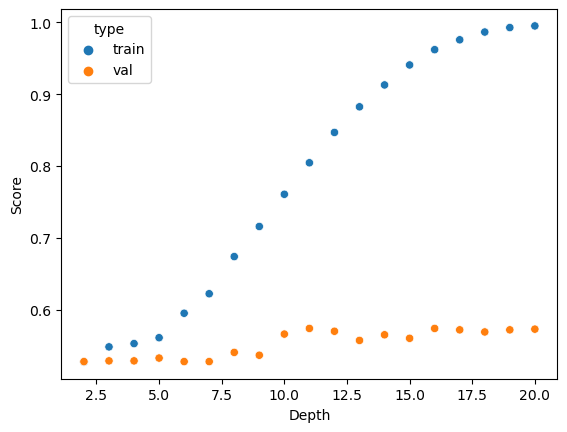

In [185]:
sns.scatterplot(x='depth', y='score', data=scores, hue='type')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.show()

In [184]:
rfc_scores = pd.DataFrame({'score':rfc_train,
                           'type':'train',
                           'depth':depth})

val_rfc_scores = pd.DataFrame({'score':rfc_val,
                               'type':'val',
                               'depth':depth})

rfc_scores = rfc_scores.append(val_rfc_scores)

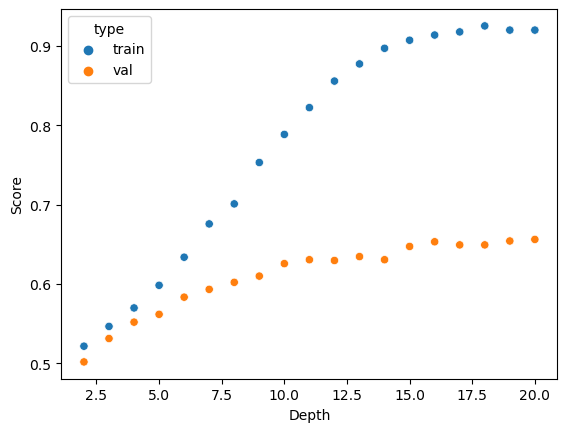

In [186]:
sns.scatterplot(x='depth', y='score', data=rfc_scores, hue='type')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.show()

In [132]:
logit = LogisticRegression(C=1, random_state=42, solver='lbfgs')
logit.fit(X_train, y_train)
y_pred = logit.predict(X_train)
print('lbfgs')
print('Train: ', logit.score(X_train, y_train))
print('Val: ', logit.score(X_val, y_val))

lbfgs
Train:  0.4716672125777923
Val:  0.4548133595284872


In [135]:
logit = LogisticRegression(C=1, random_state=42, solver='newton-cg')
logit.fit(X_train, y_train)
y_pred = logit.predict(X_train)
print('newton-cg')
print('Train: ', logit.score(X_train, y_train))
print('Val: ', logit.score(X_val, y_val))

newton-cg
Train:  0.5450376678676712
Val:  0.5275049115913556


In [140]:
logit = LogisticRegression(C=2, random_state=42, solver='liblinear')
logit.fit(X_train, y_train)
y_pred = logit.predict(X_train)
print('liblinear')
print('Train: ', logit.score(X_train, y_train))
print('Val: ', logit.score(X_val, y_val))

liblinear
Train:  0.53422862757943
Val:  0.537328094302554


In [138]:
logit = LogisticRegression(C=1, random_state=42, solver='sag')
logit.fit(X_train, y_train)
y_pred = logit.predict(X_train)
print('sag')
print('Train: ', logit.score(X_train, y_train))
print('Val: ', logit.score(X_val, y_val))

sag
Train:  0.4818211595152309
Val:  0.4538310412573674


In [139]:
logit = LogisticRegression(C=1, random_state=42, solver='saga')
logit.fit(X_train, y_train)
y_pred = logit.predict(X_train)
print('saga')
print('Train: ', logit.score(X_train, y_train))
print('Val: ', logit.score(X_val, y_val))

saga
Train:  0.4723223059285948
Val:  0.44695481335952847


In [199]:
knn_train = []
knn_val = []
depth = []

for i in range(2, 51):
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    y_pred_proba = knn.predict_proba(X_train)
    
    depth.append(i)
    knn_train.append(knn.score(X_train, y_train))
    knn_val.append(knn.score(X_val, y_val))

In [200]:
knn_scores = pd.DataFrame({'score':knn_train,
                           'type':'train',
                           'depth':depth})

val_knn_scores = pd.DataFrame({'score':knn_val,
                               'type':'val',
                               'depth':depth})

knn_scores = knn_scores.append(val_knn_scores)

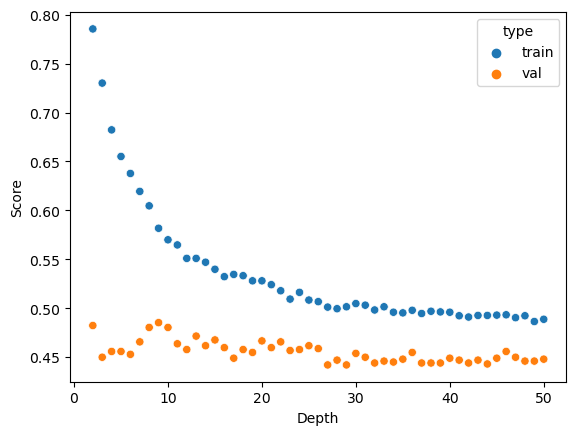

In [201]:
sns.scatterplot(x='depth', y='score', data=knn_scores, hue='type')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.show()